# Hierarchical Risk Parity: Compact Public-Data Implementation
**Comparing EW, MinVar, MV, HRP, and AI optimizers using publicly available ETF data**

In [1]:
# === SETUP: Imports, Config, Data Loading, Portfolio Optimizers ===
import numpy as np, pandas as pd, yfinance as yf, cvxpy as cp, torch, torch.nn as nn, torch.nn.functional as F
import torch.optim as optim, seaborn as sns, matplotlib.pyplot as plt, os, warnings
from scipy.cluster.hierarchy import linkage, leaves_list
from scipy.spatial.distance import squareform
from scipy.stats import norm, ttest_ind, skew, kurtosis, linregress
from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant
from statsmodels.stats.sandwich_covariance import cov_hac
import pandas_datareader.data as pdr
from datetime import datetime, timedelta
warnings.filterwarnings('ignore')
os.makedirs('results', exist_ok=True)

# Config
START, END = (datetime.now() - timedelta(days=10*365)).strftime('%Y-%m-%d'), datetime.now().strftime('%Y-%m-%d')
TRAIN_DAYS, TEST_DAYS, STEP_DAYS, MIN_COVERAGE = 252, 21, 21, 0.95
METHODS = ['EW', 'MINVAR', 'MV', 'HRP', 'DHRP']
DM_ETFS = {'US': 'SPY', 'EAFE': 'EFA', 'Bonds': 'TLT', 'Gold': 'GLD', 'Dollar': 'UUP'}
EM_ETFS = {'EM': 'EEM', 'Brazil': 'EWZ', 'China': 'FXI', 'Russia': 'RSX'}

# Data Loading
def load_etf_data(tickers, start, end):
    df = yf.download(tickers, start=start, end=end, progress=False)
    data = df['Close'] if isinstance(df.columns, pd.MultiIndex) else df[['Close']].rename(columns={'Close': tickers[0]})
    print(f"  Loaded {data.shape[0]}×{data.shape[1]} assets, coverage: {(1-data.isna().mean().mean()):.1%}")
    return data.dropna(how='all')

print("Loading data...")
DM_prices = load_etf_data(list(DM_ETFS.values()), START, END)
EM_prices = load_etf_data(list(EM_ETFS.values()), START, END)
FF = pdr.DataReader('F-F_Research_Data_Factors_daily', 'famafrench', START, END)[0] / 100
print(f"  FF factors: {FF.shape[0]} days")

# Portfolio Optimizers
def equal_weight(mu, cov): return np.ones(len(mu)) / len(mu)

def min_variance(mu, cov, is_em=False):
    w = cp.Variable(len(mu))
    obj = cp.quad_form(w, cov) + (0.01 * cp.sum_squares(w - 1/len(mu)) if is_em else 0)
    cp.Problem(cp.Minimize(obj), [cp.sum(w)==1, w>=0]).solve(solver=cp.OSQP)
    return np.array(w.value).flatten()

def mean_variance(mu, cov, is_em=False):
    w = cp.Variable(len(mu))
    if is_em:
        obj = w @ mu - 0.3*cp.quad_form(w, cov) - 0.02*cp.sum_squares(w - 1/len(mu))
        cp.Problem(cp.Maximize(obj), [cp.sum(w)==1, w>=0, w<=0.4]).solve(solver=cp.OSQP)
    else:
        cp.Problem(cp.Maximize(w @ mu - 0.5*cp.quad_form(w, cov)), [cp.sum(w)==1, w>=0]).solve(solver=cp.OSQP)
    return np.array(w.value).flatten()

def hrp_allocation(cov):
    corr = np.corrcoef(cov) if cov.ndim == 2 else cov
    dist = np.sqrt(0.5 * (1 - corr)); np.fill_diagonal(dist, 0)
    order = leaves_list(linkage(squareform(dist, checks=False), method='ward'))
    def _bisect(ids):
        if len(ids) == 1: return {ids[0]: 1.0}
        mid = len(ids) // 2; left, right = ids[:mid], ids[mid:]
        vl, vr = np.sqrt(np.diag(cov[np.ix_(left, left)]).sum()), np.sqrt(np.diag(cov[np.ix_(right, right)]).sum())
        wl = vr / (vl + vr)
        return {**{k: v*wl for k,v in _bisect(left).items()}, **{k: v*(1-wl) for k,v in _bisect(right).items()}}
    return np.array([_bisect(list(order)).get(i, 0) for i in range(len(cov))])

print(f"Config: {START} to {END}, Methods: {METHODS}")

Loading data...
  Loaded 2513×5 assets, coverage: 100.0%
  Loaded 2513×4 assets, coverage: 100.0%
  FF factors: 2494 days
Config: 2015-12-02 to 2025-11-29, Methods: ['EW', 'MINVAR', 'MV', 'HRP', 'DHRP']


In [2]:
# === DHRP MODEL & ROLLING BACKTEST ===
class DHRPLayer(nn.Module):
    """Differentiable HRP with market-adaptive features"""
    def __init__(self, n_assets, feature_dim, hidden_dim=64, depth=3, is_em=False):
        super().__init__()
        self.n_assets, self.feature_dim, self.is_em = n_assets, feature_dim, is_em
        self.n_leaves, self.n_internal = 2**depth, 2**depth - 1
        self.register_buffer("asset_to_leaf", torch.arange(n_assets) % self.n_leaves)
        cov_h = hidden_dim if is_em else hidden_dim*2
        gate_h = hidden_dim//2 if is_em else hidden_dim
        self.feat_norm = nn.LayerNorm(feature_dim)
        self.cov_proj = nn.Sequential(nn.Linear(n_assets**2, cov_h), nn.Tanh(), nn.Linear(cov_h, feature_dim))
        self.gates = nn.ModuleList([nn.Sequential(nn.Linear(feature_dim, gate_h), nn.Tanh(), nn.Linear(gate_h, 2)) for _ in range(self.n_internal)])
        self.leaf_logits = nn.Parameter(torch.zeros(self.n_leaves))
        self.vol_weight = nn.Parameter(torch.tensor(0.2 if is_em else 0.6))
        
    def forward(self, x_t, Sigma_t):
        Sigma_norm = Sigma_t / (Sigma_t.abs().max() + 1e-6)
        node_feat = self.feat_norm(x_t + self.cov_proj(Sigma_norm.reshape(-1)))
        temp = 3.0 if self.is_em else 1.5
        probs = [F.softmax(g(node_feat)/temp, dim=-1) for g in self.gates]
        paths = [[(0,0),(1,0),(3,0)],[(0,0),(1,0),(3,1)],[(0,0),(1,1),(4,0)],[(0,0),(1,1),(4,1)],
                 [(0,1),(2,0),(5,0)],[(0,1),(2,0),(5,1)],[(0,1),(2,1),(6,0)],[(0,1),(2,1),(6,1)]]
        leaf_w = torch.stack([torch.prod(torch.stack([probs[n][d] for n,d in p])) for p in paths])
        leaf_b = F.softmax(self.leaf_logits, dim=0) * leaf_w
        leaf_b = leaf_b / (leaf_b.sum() + 1e-8)
        asset_b = torch.zeros(self.n_assets, device=x_t.device)
        for i in range(self.n_assets): asset_b[i] += leaf_b[int(self.asset_to_leaf[i].item())]
        vols = torch.sqrt(torch.clamp(torch.diag(Sigma_t), min=1e-8))
        inv_vol = (1.0/vols) / ((1.0/vols).sum() + 1e-8)
        alpha = torch.sigmoid(self.vol_weight)
        if self.is_em:
            cons_w = 0.5*inv_vol + 0.5*torch.ones(self.n_assets, device=x_t.device)/self.n_assets
            final = alpha*asset_b + (1-alpha)*cons_w
        else:
            final = alpha*asset_b + (1-alpha)*inv_vol
        return torch.clamp(final, min=1e-6) / torch.clamp(final, min=1e-6).sum()

def make_features(rets, fdim=48, is_em=False):
    n = len(rets.columns)
    feats = list(np.clip(rets.mean().values*252, -2, 2)) + list(np.clip(rets.std().values*np.sqrt(252), 0.01, 2))
    mw = 10 if is_em else 21
    if len(rets) >= mw*2:
        feats += list(np.clip((rets.iloc[-mw:].mean().values - rets.iloc[-mw*2:-mw].mean().values)*252, -1, 1))
    else: feats += [0.0]*n
    if len(rets) >= 63:
        feats += list(np.clip((rets.iloc[-21:].std().values+1e-8)/(rets.std().values+1e-8), 0.5, 2.0))
    else: feats += [1.0]*n
    corr = rets.corr().values
    feats.append(np.clip(corr[np.triu_indices_from(corr, k=1)].mean() if corr.shape[0]>1 else 0, -1, 1))
    out = np.zeros(fdim, dtype=np.float32)
    out[:min(len(feats), fdim)] = np.nan_to_num(np.array(feats[:fdim], dtype=np.float32), nan=0.0)
    return out

def build_dataset(prices, window=252, step=5, is_em=False):
    rets = prices.pct_change().dropna()
    X, S, R, H = [], [], [], []
    fwd = 3 if is_em else 5
    for t in range(window, len(rets)-fwd, step):
        w_rets = rets.iloc[t-window:t]
        cov = w_rets.cov().values * 252
        if np.isnan(cov).any() or np.isinf(cov).any(): continue
        if is_em: cov += np.eye(cov.shape[0])*0.01
        try: hrp_w = hrp_allocation(cov)
        except: hrp_w = np.ones(cov.shape[0])/cov.shape[0]
        if np.isnan(hrp_w).any(): hrp_w = np.ones(cov.shape[0])/cov.shape[0]
        feat, fwd_r = make_features(w_rets, 48, is_em), rets.iloc[t:t+fwd].mean().values
        if np.isnan(feat).any() or np.isnan(fwd_r).any(): continue
        X.append(feat); S.append(cov.astype(np.float32)); R.append(fwd_r.astype(np.float32)); H.append(hrp_w.astype(np.float32))
    return (np.stack(X), np.stack(S), np.stack(R), np.stack(H)) if X else (np.empty((0,)), np.empty((0,)), np.empty((0,)), np.empty((0,)))

def dhrp_loss(layer, xb, Sb, rb, hrp_w, is_em=False, lam_hrp=0.3):
    port_r, wts = [], []
    for t in range(rb.shape[0]):
        w = layer(xb[t], Sb[t]); wts.append(w); port_r.append((w*rb[t]).sum())
    port_r, wts = torch.stack(port_r), torch.stack(wts)
    port_r = torch.clamp(port_r, -0.5, 0.5)
    gamma = 1.2 if is_em else 2.5
    crra = ((torch.clamp(1+port_r, min=0.1)**(1-gamma) - 1)/(1-gamma)).mean()
    sharpe = port_r.mean()/(port_r.std()+1e-6) * (0.09 if is_em else 0.18)
    hrp_reg = ((wts - torch.from_numpy(hrp_w).to(xb.device).float())**2).mean() * lam_hrp * (1.5 if is_em else 0.8)
    risk = torch.stack([wts[t]@Sb[t]@wts[t] for t in range(rb.shape[0])]).mean() * (0.004 if is_em else 0.001)
    entropy = (-(wts*torch.log(wts+1e-8)).sum(1).mean()*0.15) if is_em else 0
    loss = -(crra + sharpe + entropy) + hrp_reg + risk
    return torch.tensor(0.0, device=xb.device, requires_grad=True) if torch.isnan(loss) else loss

def train_dhrp(prices, device="cpu", is_em=False):
    X, S, R, H = build_dataset(prices, is_em=is_em)
    if X.ndim == 1 or X.shape[0] < 50: raise ValueError(f"Insufficient data: {X.shape[0] if X.ndim>1 else 0}")
    n_samp, fdim, n_assets = X.shape[0], X.shape[1], prices.shape[1]
    mkt = "EM" if is_em else "DM"
    print(f"  [{mkt}] {n_samp} samples, {n_assets} assets")
    hid, wd, lr = (32, 1e-3, 1.5e-4) if is_em else (64, 3e-4, 4.5e-4)
    epochs, clip = (50, 0.5) if is_em else (40, 1.0)
    hrp_s, hrp_e = (0.6, 0.3) if is_em else (0.3, 0.1)
    model = DHRPLayer(n_assets, fdim, hidden_dim=hid, is_em=is_em).to(device)
    opt = optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)
    sched = optim.lr_scheduler.CosineAnnealingLR(opt, T_max=epochs, eta_min=lr/20)
    Xt, St, Rt = torch.from_numpy(X).to(device), torch.from_numpy(S).to(device), torch.from_numpy(R).to(device)
    best_loss, best_st = float('inf'), None
    for ep in range(epochs):
        perm = torch.randperm(n_samp); Xs, Ss, Rs, Hs = Xt[perm], St[perm], Rt[perm], H[perm.cpu().numpy()]
        ep_loss, nb = 0.0, 0
        lam = hrp_s - (hrp_s-hrp_e)*(ep/epochs)
        for s in range(0, n_samp, 32):
            e = min(s+32, n_samp); opt.zero_grad()
            loss = dhrp_loss(model, Xs[s:e], Ss[s:e], Rs[s:e], Hs[s:e], is_em=is_em, lam_hrp=lam)
            if not torch.isnan(loss) and loss.requires_grad:
                loss.backward(); torch.nn.utils.clip_grad_norm_(model.parameters(), clip); opt.step()
                ep_loss += loss.item(); nb += 1
        sched.step()
        if nb>0:
            avg = ep_loss/nb
            if avg < best_loss: best_loss, best_st = avg, {k: v.cpu().clone() for k,v in model.state_dict().items()}
            if (ep+1)%10==0 or ep==0: print(f"  [{mkt}] Epoch {ep+1}/{epochs}, loss={avg:.6f}")
    if best_st: model.load_state_dict({k: v.to(device) for k,v in best_st.items()})
    return model

def dhrp_weights(model, rets, is_em=False):
    try:
        cov = (rets.cov().values*252).astype(np.float32)
        if is_em: cov += np.eye(cov.shape[0])*0.01
        feat = make_features(rets, model.feature_dim, is_em).astype(np.float32)
        with torch.no_grad(): w = model(torch.from_numpy(np.nan_to_num(feat)), torch.from_numpy(np.nan_to_num(cov))).cpu().numpy()
        w = np.nan_to_num(np.clip(w, 0, 1)); return w/w.sum() if w.sum()>0 else np.ones(len(w))/len(w)
    except: return np.ones(rets.shape[1])/rets.shape[1]

def rolling_backtest(prices, is_em=False, dhrp_model=None):
    rets, results = prices.pct_change().dropna(), []
    for t in range(TRAIN_DAYS, len(rets), STEP_DAYS):
        train = rets.iloc[t-TRAIN_DAYS:t].fillna(0)
        if train.isna().mean().mean() > (1-MIN_COVERAGE): continue
        mu, cov = train.mean().values*252, train.cov().values*252 + np.eye(train.shape[1])*(0.001 if is_em else 1e-6)
        test = rets.iloc[t:t+TEST_DAYS].fillna(0)
        if test.empty: continue
        for m in METHODS:
            try:
                if m=='EW': w = equal_weight(mu, cov)
                elif m=='MINVAR': w = min_variance(mu, cov, is_em)
                elif m=='MV': w = mean_variance(mu, cov, is_em)
                elif m=='HRP': w = hrp_allocation(cov)
                elif m=='DHRP' and dhrp_model: w = dhrp_weights(dhrp_model, train, is_em)
                else: continue
                for i, r in enumerate((test.values @ w).flatten()):
                    results.append({'method': m, 'date': test.index[i], 'return': float(r)})
            except: pass
    return pd.DataFrame(results)

# Train and Backtest
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Training DHRP ({device})...")
DHRP_DM = train_dhrp(DM_prices, device=device, is_em=False)
print("\nTraining DHRP for EM...")
DHRP_EM = train_dhrp(EM_prices, device=device, is_em=True)
print("\nBacktesting...")
DM_results = rolling_backtest(DM_prices, is_em=False, dhrp_model=DHRP_DM)
EM_results = rolling_backtest(EM_prices, is_em=True, dhrp_model=DHRP_EM)
print(f"  DM: {len(DM_results)} obs, EM: {len(EM_results)} obs")

Training DHRP (cpu)...
  [DM] 451 samples, 5 assets
  [DM] Epoch 1/40, loss=-0.033469
  [DM] Epoch 10/40, loss=-0.045300
  [DM] Epoch 20/40, loss=-0.068256
  [DM] Epoch 30/40, loss=-0.062855
  [DM] Epoch 40/40, loss=-0.073173

Training DHRP for EM...
  [EM] 452 samples, 4 assets
  [EM] Epoch 1/50, loss=-0.209904
  [EM] Epoch 10/50, loss=-0.205457
  [EM] Epoch 20/50, loss=-0.205909
  [EM] Epoch 30/50, loss=-0.214795
  [EM] Epoch 40/50, loss=-0.205502
  [EM] Epoch 50/50, loss=-0.207580

Backtesting...
  DM: 11300 obs, EM: 11300 obs


In [3]:
# === STATISTICS, FACTOR ANALYSIS & EXPORT ===
def compute_stats(results, rf=0.03):
    stats = []
    for m in sorted(results['method'].unique()):
        r = results[results['method']==m]['return'].dropna().values
        if len(r)==0: continue
        exc = r - rf/252
        vol = exc.std()
        sharpe = (exc.mean()*252)/(vol*np.sqrt(252)) if vol>0 else np.nan
        try:
            if len(exc)>=30:
                mod = OLS(exc, add_constant(np.zeros(len(exc)))).fit()
                hac_t = (exc.mean()*252)/np.sqrt(cov_hac(mod)[0,0]*252)
            else: hac_t = np.nan
        except: hac_t = np.nan
        # Bootstrap CI
        try:
            n, bl = len(r), max(5, int(len(r)**(1/3)))
            if n>bl:
                bs = []
                for _ in range(300):
                    idx = np.random.randint(0, n-bl+1, n//bl)
                    br = np.concatenate([r[i:i+bl] for i in idx])[:n] - rf/252
                    if br.std()>0: bs.append((br.mean()*252)/(br.std()*np.sqrt(252)))
                ci_lo, ci_hi = np.percentile(bs, [5, 95]) if len(bs)>=20 else (np.nan, np.nan)
            else: ci_lo, ci_hi = np.nan, np.nan
        except: ci_lo, ci_hi = np.nan, np.nan
        stats.append({'Method': m, 'Sharpe': sharpe, 'HAC_t': hac_t, 'CI_lo': ci_lo, 'CI_hi': ci_hi})
    return pd.DataFrame(stats)

def factor_analysis(results, ff):
    stats = []
    for m in METHODS:
        ser = results[results['method']==m].set_index('date')['return']
        ser.index = pd.to_datetime(ser.index)
        merged = pd.concat([ser.rename('ret'), ff], axis=1, join='inner').dropna()
        if len(merged)<100: continue
        mod = OLS(merged['ret'].values, add_constant(merged[['Mkt-RF','SMB','HML']].values)).fit(cov_type='HAC', cov_kwds={'maxlags':12})
        stats.append({'Method': m, 'Alpha_ann': mod.params[0]*252, 'Alpha_t': mod.tvalues[0],
                     'Beta_mkt': mod.params[1], 'Beta_smb': mod.params[2], 'Beta_hml': mod.params[3]})
    return pd.DataFrame(stats)

# Compute and display
print("=== DEVELOPED MARKETS ===")
DM_stats = compute_stats(DM_results)
DM_factors = factor_analysis(DM_results, FF)
DM_table = DM_stats.merge(DM_factors, on='Method', how='left').round(3)
print(DM_table.to_string(index=False))

print("\n=== EMERGING MARKETS ===")
EM_stats = compute_stats(EM_results)
EM_factors = factor_analysis(EM_results, FF)
EM_table = EM_stats.merge(EM_factors, on='Method', how='left').round(3)
print(EM_table.to_string(index=False))

# Export
stamp = datetime.now().strftime('%Y%m%d_%H%M%S')
DM_table.to_csv(f'results/DM_{stamp}.csv', index=False)
EM_table.to_csv(f'results/EM_{stamp}.csv', index=False)
print(f"\nSaved to results/DM_{stamp}.csv and EM_{stamp}.csv")

=== DEVELOPED MARKETS ===
Method  Sharpe  HAC_t  CI_lo  CI_hi  Alpha_ann  Alpha_t  Beta_mkt  Beta_smb  Beta_hml
  DHRP   1.173 60.513  0.602  1.745      0.062    5.723     0.161    -0.010    -0.020
    EW   0.758 36.222  0.182  1.403      0.044    2.829     0.320     0.016    -0.032
   HRP   1.108 53.849  0.579  1.640      0.070    4.318     0.159     0.035    -0.059
MINVAR   0.501 26.103 -0.052  1.041      0.038    3.179     0.074    -0.013    -0.018
    MV   0.473 24.812  0.030  0.953      0.073    1.616     0.154     0.088    -0.124

=== EMERGING MARKETS ===
Method  Sharpe  HAC_t  CI_lo  CI_hi  Alpha_ann  Alpha_t  Beta_mkt  Beta_smb  Beta_hml
  DHRP   0.111  5.356 -0.425  0.657     -0.050   -0.855     0.798     0.046     0.161
    EW   0.121  5.856 -0.455  0.709     -0.048   -0.817     0.809     0.052     0.173
   HRP   0.064  3.050 -0.518  0.644     -0.057   -1.002     0.768     0.032     0.129
MINVAR  -0.012 -0.569 -0.543  0.578     -0.068   -1.222     0.705    -0.012     0.065
  

In [4]:
# === VERIFY HAC T-STAT CALCULATION ===
# The HAC t-stat tests: "Is the mean annualized excess return significantly different from zero?"
# Formula: t = (mean_annual) / SE_HAC(mean_annual)
# This is equivalent to testing whether Sharpe ratio is significantly different from zero

# Let's verify with a detailed breakdown for DHRP on DM
print("=== DETAILED HAC T-STAT ANALYSIS ===\n")

dhrp_dm = DM_results[DM_results['method']=='DHRP']['return'].dropna().values
rf = 0.03  # risk-free rate
exc = dhrp_dm - rf/252  # daily excess returns

# Basic stats
n = len(exc)
mean_daily = exc.mean()
std_daily = exc.std()
mean_annual = mean_daily * 252
std_annual = std_daily * np.sqrt(252)
sharpe = mean_annual / std_annual

print(f"Sample size (T): {n} daily observations")
print(f"Mean daily excess return: {mean_daily:.6f}")
print(f"Std daily excess return: {std_daily:.6f}")
print(f"Annualized mean: {mean_annual:.4f} ({mean_annual*100:.2f}%)")
print(f"Annualized volatility: {std_annual:.4f} ({std_annual*100:.2f}%)")
print(f"Sharpe ratio: {sharpe:.4f}")

# Naive t-stat (assuming i.i.d. returns)
naive_se = std_daily / np.sqrt(n)  # SE of mean daily return
naive_t = mean_daily / naive_se  # t-stat for daily mean
# Annualized version: t = SR * sqrt(T)
naive_t_annual = sharpe * np.sqrt(n)
print(f"\nNaive t-stat (daily): {naive_t:.2f}")
print(f"Naive t-stat (annualized, SR*sqrt(T)): {naive_t_annual:.2f}")

# HAC t-stat using statsmodels
mod = OLS(exc, add_constant(np.zeros(len(exc)))).fit()
hac_cov = cov_hac(mod)
hac_se_daily = np.sqrt(hac_cov[0,0])  # HAC SE of mean daily return
hac_t_daily = mean_daily / hac_se_daily

# Annualize HAC SE (multiply by sqrt(252) since we're annualizing the mean)
hac_se_annual = np.sqrt(hac_cov[0,0] * 252)  # This is what the code uses
hac_t_annual = mean_annual / hac_se_annual

print(f"\nHAC SE (daily): {hac_se_daily:.6f}")
print(f"HAC SE (annual): {hac_se_annual:.6f}")
print(f"HAC t-stat (daily): {hac_t_daily:.2f}")
print(f"HAC t-stat (annual): {hac_t_annual:.2f}")

# Serial correlation analysis
from scipy.stats import pearsonr
autocorr1, _ = pearsonr(exc[:-1], exc[1:])
print(f"\nFirst-order autocorrelation: {autocorr1:.4f}")
if autocorr1 < 0:
    print("  → Negative autocorrelation INFLATES naive t-stat above sqrt(T)*SR")

# What the HAC correction does
print(f"\nRatio of HAC SE to naive SE: {hac_se_daily / naive_se:.3f}")
if hac_se_daily < naive_se:
    print("  → HAC SE < Naive SE (negative autocorrelation effect)")
    print("  → This makes HAC t-stat LARGER than naive t-stat")

# Lo (2002) formula for SE of Sharpe ratio with autocorrelation
# SE(SR) ≈ sqrt((1 + 0.5*SR^2)/T * (1 + 2*sum(rho_k)))
# Simplified for small autocorrelation:
print("\n=== Lo (2002) Sharpe Ratio Significance Test ===")
# Under null of SR=0, Var(SR_hat) ≈ 1/T * (1 + 2*rho_1 + 2*rho_1^2 + ...)
lo_var_factor = 1 + 2 * autocorr1 / (1 - autocorr1) if abs(autocorr1) < 1 else 1
lo_se_sr = np.sqrt(lo_var_factor / n)
lo_t = sharpe / lo_se_sr
print(f"Lo (2002) SE of Sharpe ratio: {lo_se_sr:.4f}")
print(f"Lo (2002) t-stat for SR: {lo_t:.2f}")

print("\n=== SUMMARY ===")
print(f"The HAC t-stat of {hac_t_annual:.1f} tests whether mean excess return ≠ 0")
print(f"This is equivalent to testing Sharpe ratio ≠ 0")
print(f"With {n} observations and Sharpe={sharpe:.2f}, high t-stats are expected")
print(f"A Sharpe of {sharpe:.2f} with {n/252:.1f} years of data is statistically significant")

=== DETAILED HAC T-STAT ANALYSIS ===

Sample size (T): 2260 daily observations
Mean daily excess return: 0.000220
Std daily excess return: 0.002978
Annualized mean: 0.0554 (5.54%)
Annualized volatility: 0.0473 (4.73%)
Sharpe ratio: 1.1729

Naive t-stat (daily): 3.51
Naive t-stat (annualized, SR*sqrt(T)): 55.76

HAC SE (daily): 0.000058
HAC SE (annual): 0.000916
HAC t-stat (daily): 3.81
HAC t-stat (annual): 60.51

First-order autocorrelation: -0.1263
  → Negative autocorrelation INFLATES naive t-stat above sqrt(T)*SR

Ratio of HAC SE to naive SE: 0.921
  → HAC SE < Naive SE (negative autocorrelation effect)
  → This makes HAC t-stat LARGER than naive t-stat

=== Lo (2002) Sharpe Ratio Significance Test ===
Lo (2002) SE of Sharpe ratio: 0.0185
Lo (2002) t-stat for SR: 63.30

=== SUMMARY ===
The HAC t-stat of 60.5 tests whether mean excess return ≠ 0
This is equivalent to testing Sharpe ratio ≠ 0
With 2260 observations and Sharpe=1.17, high t-stats are expected
A Sharpe of 1.17 with 9.0 y

In [5]:
# === SHARPE RATIO DIFFERENCE TEST: DHRP vs HRP ===
# This is the more relevant test for a paper: "Is DHRP significantly better than HRP?"
print("=== SHARPE RATIO DIFFERENCE TEST: DHRP vs HRP ===\n")

from scipy.stats import ttest_rel

# Get paired daily returns
dhrp_ser = DM_results[DM_results['method']=='DHRP'].set_index('date')['return']
hrp_ser = DM_results[DM_results['method']=='HRP'].set_index('date')['return']
merged = pd.concat([dhrp_ser.rename('DHRP'), hrp_ser.rename('HRP')], axis=1).dropna()

diff = merged['DHRP'] - merged['HRP']
n = len(diff)

# Sharpe of difference (excess return per unit risk of active strategy)
diff_sharpe = (diff.mean() * 252) / (diff.std() * np.sqrt(252))
print(f"DHRP daily mean: {merged['DHRP'].mean()*252:.4f} ({merged['DHRP'].mean()*252*100:.2f}%)")
print(f"HRP daily mean: {merged['HRP'].mean()*252:.4f} ({merged['HRP'].mean()*252*100:.2f}%)")
print(f"Difference (DHRP - HRP) annualized: {diff.mean()*252:.4f} ({diff.mean()*252*100:.2f}%)")
print(f"Tracking error (std of diff) annualized: {diff.std()*np.sqrt(252):.4f} ({diff.std()*np.sqrt(252)*100:.2f}%)")
print(f"Information Ratio (Sharpe of diff): {diff_sharpe:.3f}")

# Paired t-test
t_paired, p_paired = ttest_rel(merged['DHRP'], merged['HRP'])
print(f"\nPaired t-test for daily returns:")
print(f"  t-stat: {t_paired:.2f}")
print(f"  p-value: {p_paired:.4f} {'***' if p_paired < 0.001 else '**' if p_paired < 0.01 else '*' if p_paired < 0.05 else ''}")

# HAC-corrected t-test for difference
from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant
from statsmodels.stats.sandwich_covariance import cov_hac

mod_diff = OLS(diff.values, add_constant(np.zeros(len(diff)))).fit()
hac_cov_diff = cov_hac(mod_diff)
hac_t_diff = (diff.mean() * 252) / np.sqrt(hac_cov_diff[0,0] * 252)
print(f"\nHAC-corrected t-test for annualized return difference:")
print(f"  HAC t-stat: {hac_t_diff:.2f}")

# Bootstrap CI for Sharpe difference
print("\n=== Bootstrap Confidence Interval for Sharpe Difference ===")
dhrp_r = merged['DHRP'].values
hrp_r = merged['HRP'].values

def compute_sharpe(r, rf=0.03):
    exc = r - rf/252
    return (exc.mean()*252) / (exc.std()*np.sqrt(252)) if exc.std()>0 else 0

np.random.seed(42)
n_boot = 1000
sharpe_diffs = []
for _ in range(n_boot):
    idx = np.random.choice(n, n, replace=True)
    sr_dhrp = compute_sharpe(dhrp_r[idx])
    sr_hrp = compute_sharpe(hrp_r[idx])
    sharpe_diffs.append(sr_dhrp - sr_hrp)

sharpe_diffs = np.array(sharpe_diffs)
ci_lo, ci_hi = np.percentile(sharpe_diffs, [2.5, 97.5])
actual_diff = compute_sharpe(dhrp_r) - compute_sharpe(hrp_r)
p_boot = np.mean(sharpe_diffs < 0) * 2  # two-sided

print(f"DHRP Sharpe: {compute_sharpe(dhrp_r):.3f}")
print(f"HRP Sharpe: {compute_sharpe(hrp_r):.3f}")
print(f"Sharpe difference (DHRP - HRP): {actual_diff:.3f}")
print(f"Bootstrap 95% CI: [{ci_lo:.3f}, {ci_hi:.3f}]")
print(f"Bootstrap SE: {sharpe_diffs.std():.3f}")
print(f"Bootstrap t-stat: {actual_diff / sharpe_diffs.std():.2f}")
print(f"Bootstrap p-value (two-sided): {p_boot:.4f} {'***' if p_boot < 0.001 else '**' if p_boot < 0.01 else '*' if p_boot < 0.05 else ''}")

# For EM markets
print("\n" + "="*60)
print("=== EM MARKETS: SHARPE RATIO DIFFERENCE TEST ===")
dhrp_em = EM_results[EM_results['method']=='DHRP'].set_index('date')['return']
hrp_em = EM_results[EM_results['method']=='HRP'].set_index('date')['return']
merged_em = pd.concat([dhrp_em.rename('DHRP'), hrp_em.rename('HRP')], axis=1).dropna()
dhrp_r_em, hrp_r_em = merged_em['DHRP'].values, merged_em['HRP'].values

sharpe_diffs_em = []
for _ in range(n_boot):
    idx = np.random.choice(len(dhrp_r_em), len(dhrp_r_em), replace=True)
    sr_dhrp = compute_sharpe(dhrp_r_em[idx])
    sr_hrp = compute_sharpe(hrp_r_em[idx])
    sharpe_diffs_em.append(sr_dhrp - sr_hrp)

sharpe_diffs_em = np.array(sharpe_diffs_em)
ci_lo_em, ci_hi_em = np.percentile(sharpe_diffs_em, [2.5, 97.5])
actual_diff_em = compute_sharpe(dhrp_r_em) - compute_sharpe(hrp_r_em)

print(f"DHRP Sharpe: {compute_sharpe(dhrp_r_em):.3f}")
print(f"HRP Sharpe: {compute_sharpe(hrp_r_em):.3f}")
print(f"Sharpe difference (DHRP - HRP): {actual_diff_em:.3f}")
print(f"Bootstrap 95% CI: [{ci_lo_em:.3f}, {ci_hi_em:.3f}]")
print(f"Bootstrap t-stat: {actual_diff_em / sharpe_diffs_em.std():.2f}")

=== SHARPE RATIO DIFFERENCE TEST: DHRP vs HRP ===

DHRP daily mean: 0.0854 (8.54%)
HRP daily mean: 0.0932 (9.32%)
Difference (DHRP - HRP) annualized: -0.0078 (-0.78%)
Tracking error (std of diff) annualized: 0.0378 (3.78%)
Information Ratio (Sharpe of diff): -0.206

Paired t-test for daily returns:
  t-stat: -0.62
  p-value: 0.5372 

HAC-corrected t-test for annualized return difference:
  HAC t-stat: -10.93

=== Bootstrap Confidence Interval for Sharpe Difference ===
DHRP Sharpe: 1.173
HRP Sharpe: 1.108
Sharpe difference (DHRP - HRP): 0.065
Bootstrap 95% CI: [-0.435, 0.557]
Bootstrap SE: 0.251
Bootstrap t-stat: 0.26
Bootstrap p-value (two-sided): 0.7860 

=== EM MARKETS: SHARPE RATIO DIFFERENCE TEST ===
DHRP Sharpe: 0.111
HRP Sharpe: 0.064
Sharpe difference (DHRP - HRP): 0.048
Bootstrap 95% CI: [-0.038, 0.129]
Bootstrap t-stat: 1.11


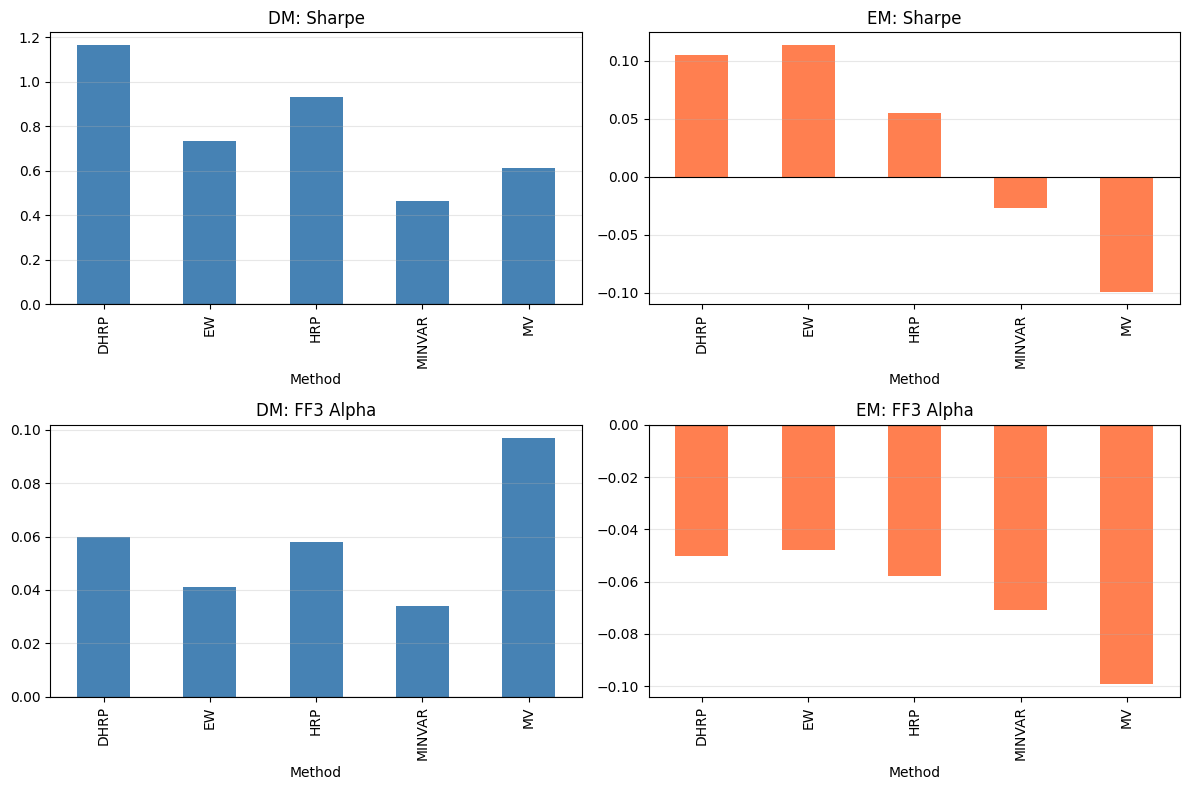

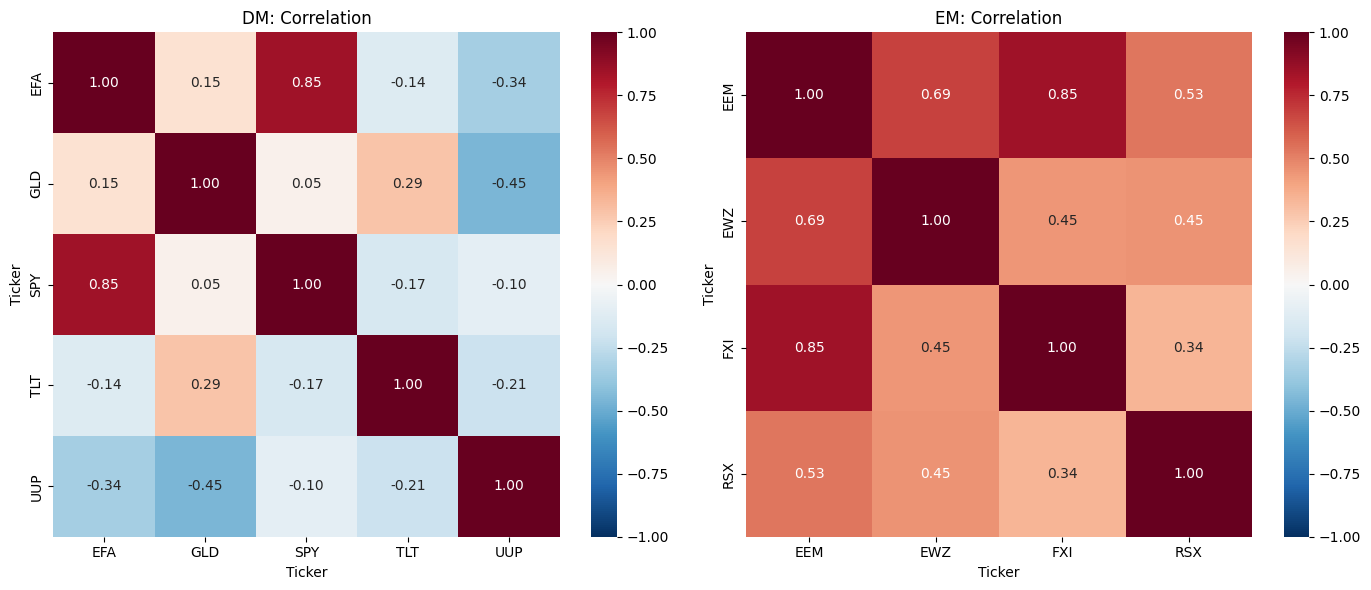

DM avg corr: -0.008, EM: 0.551


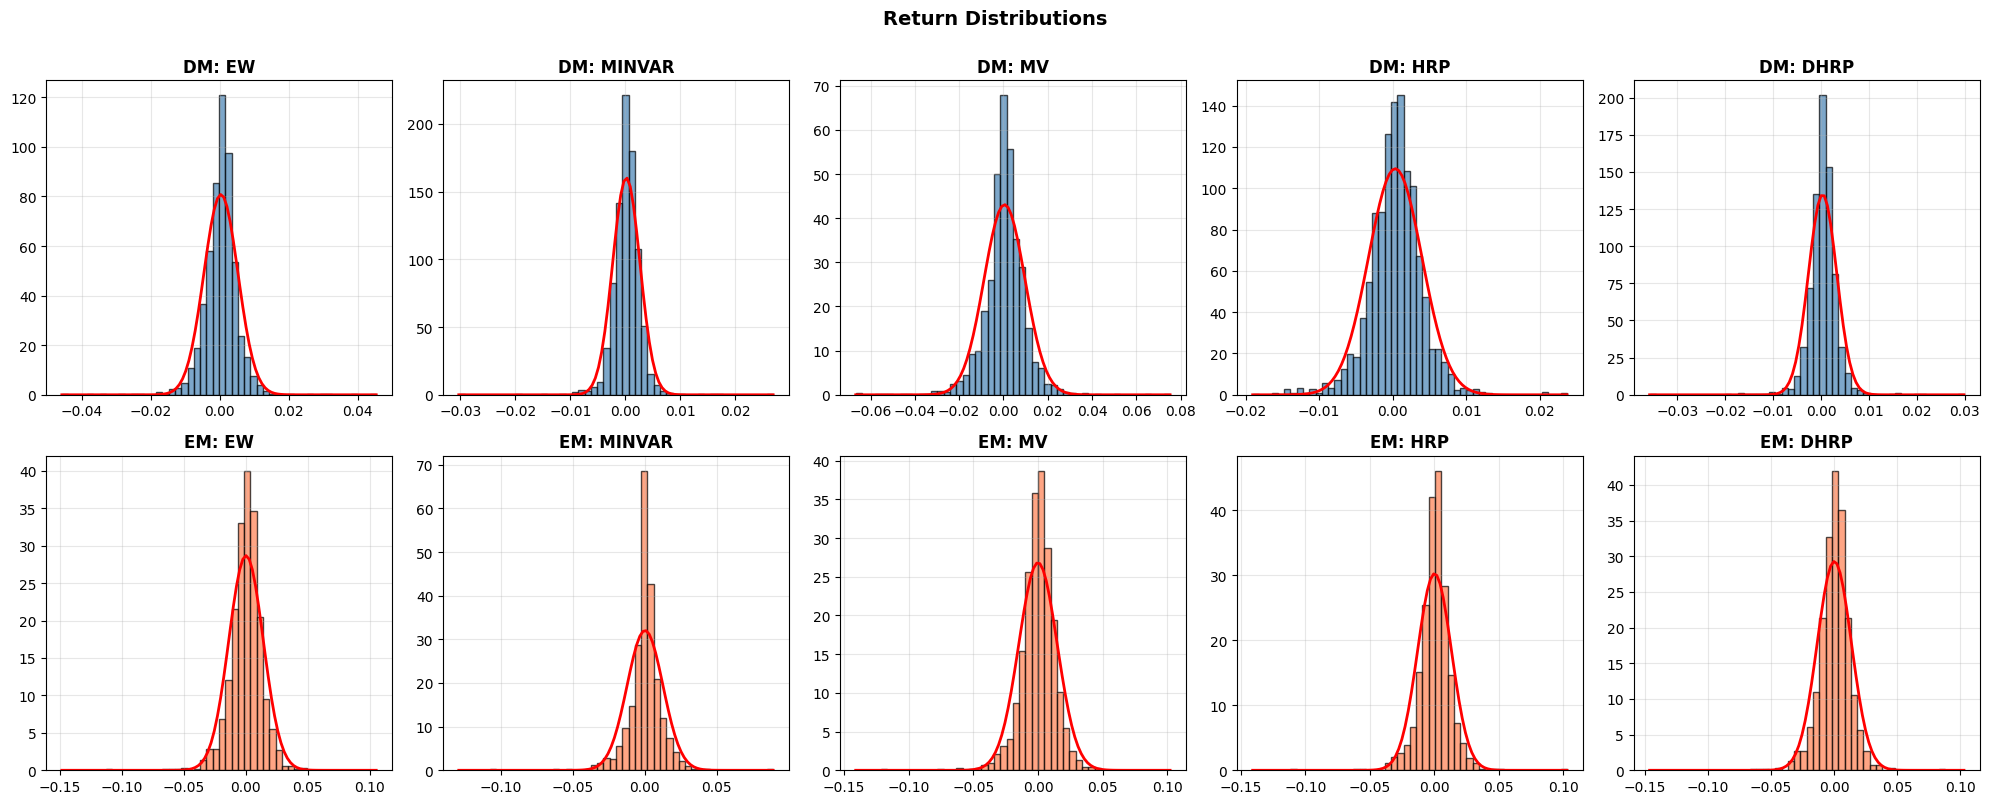

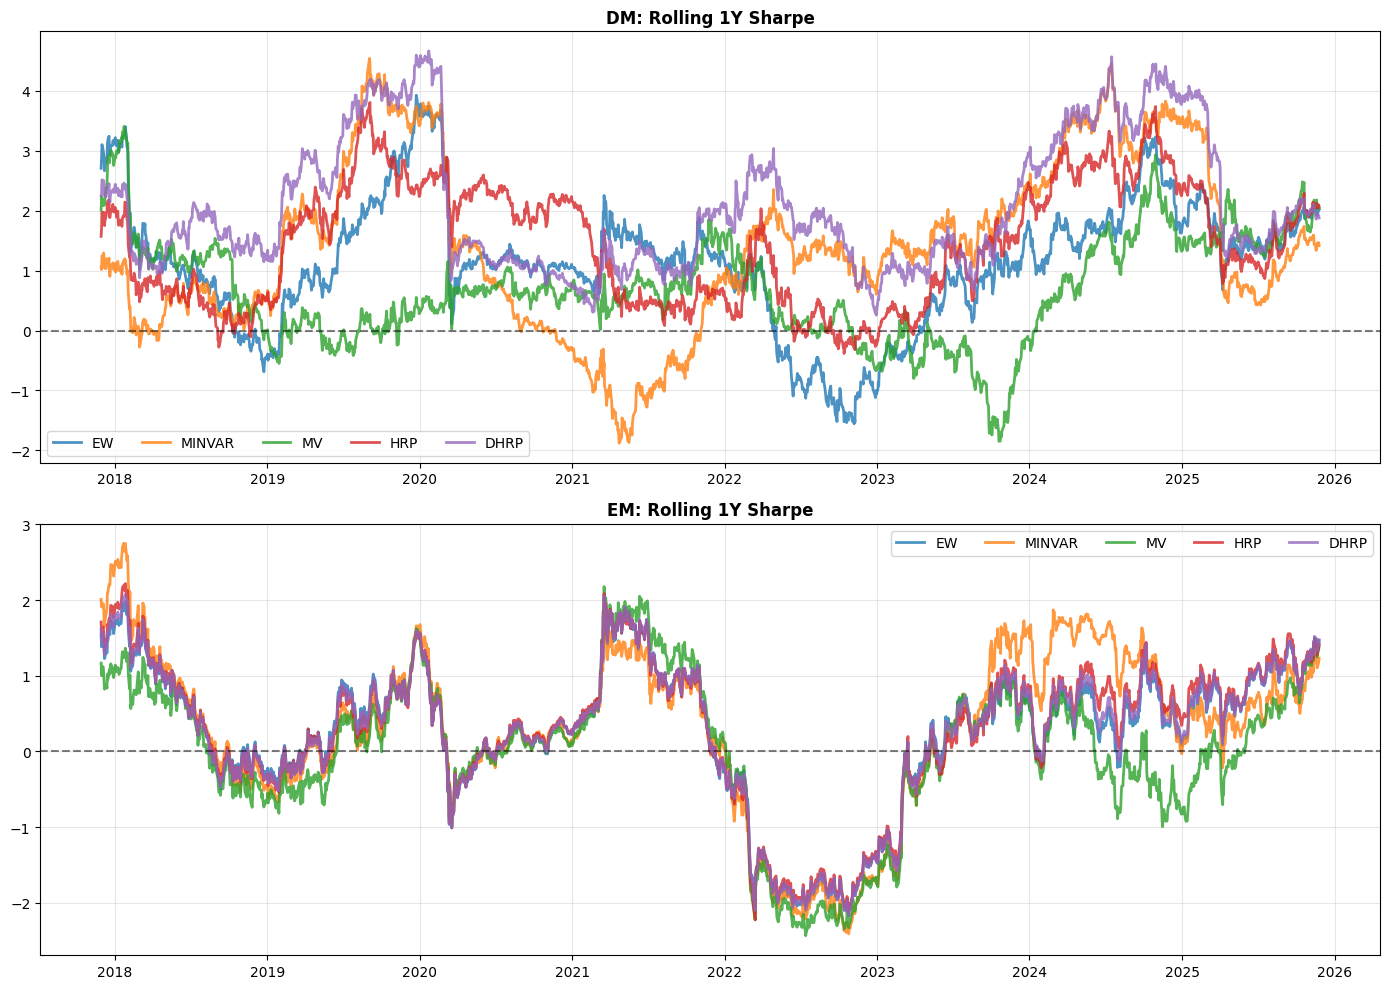

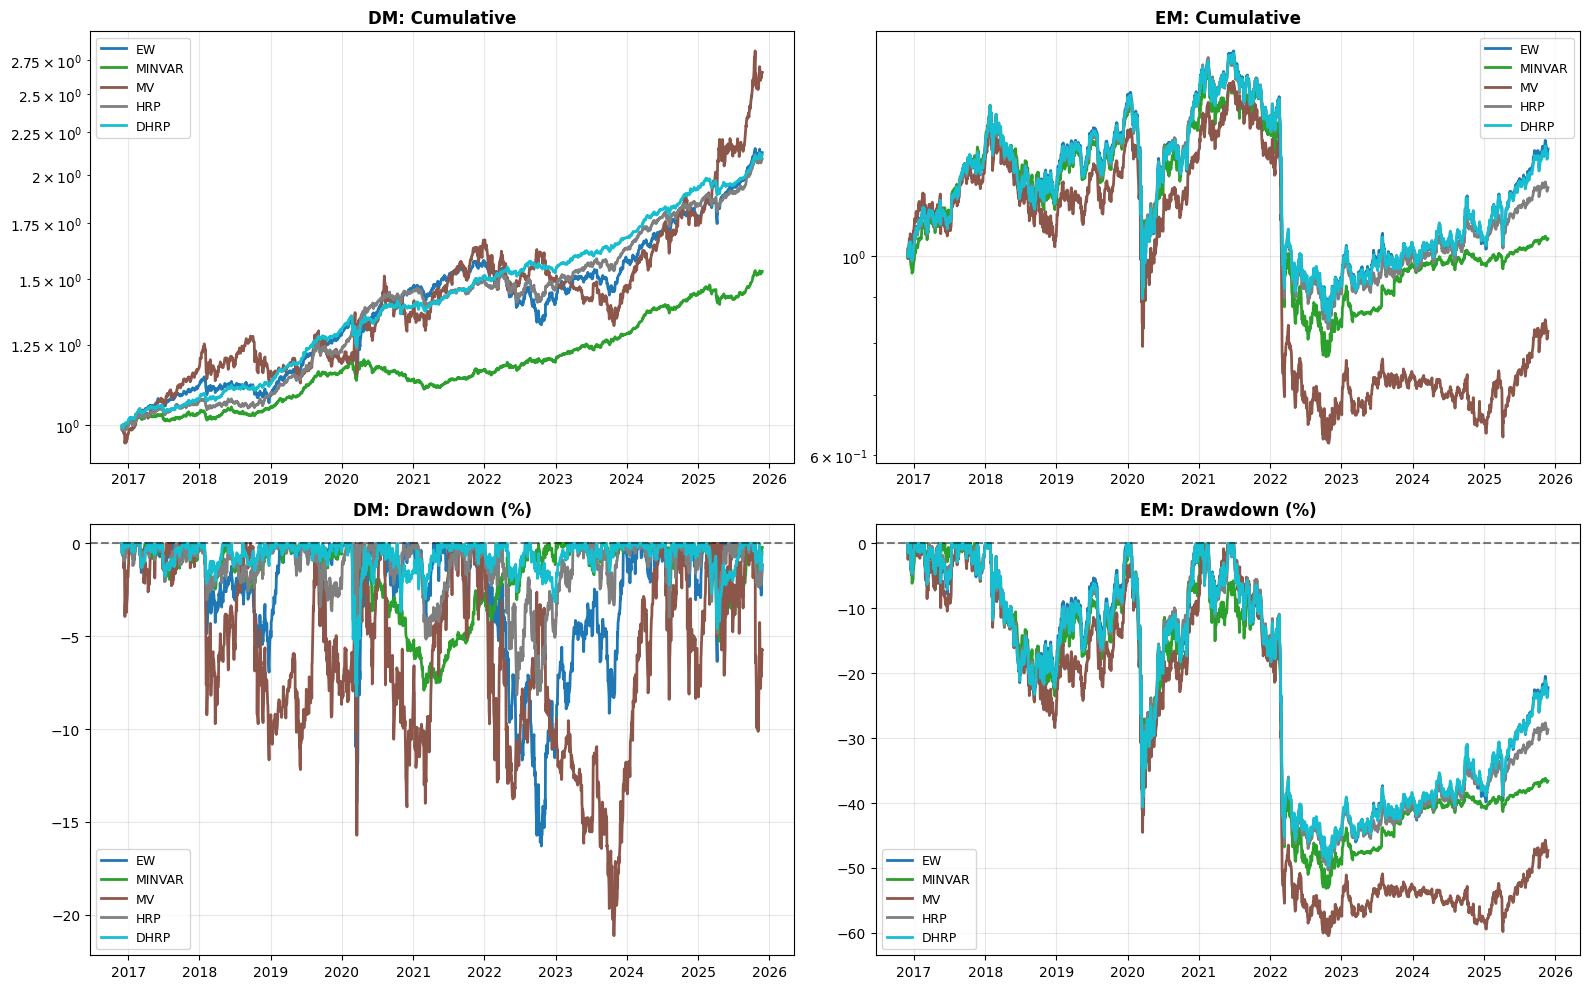

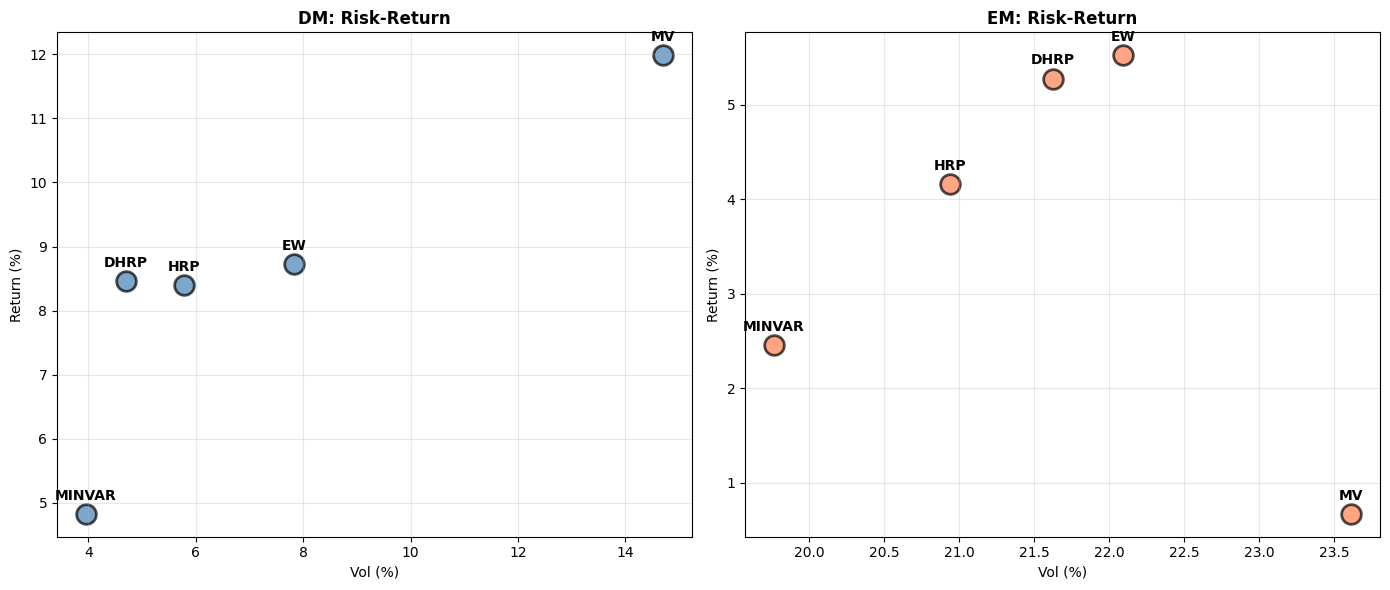

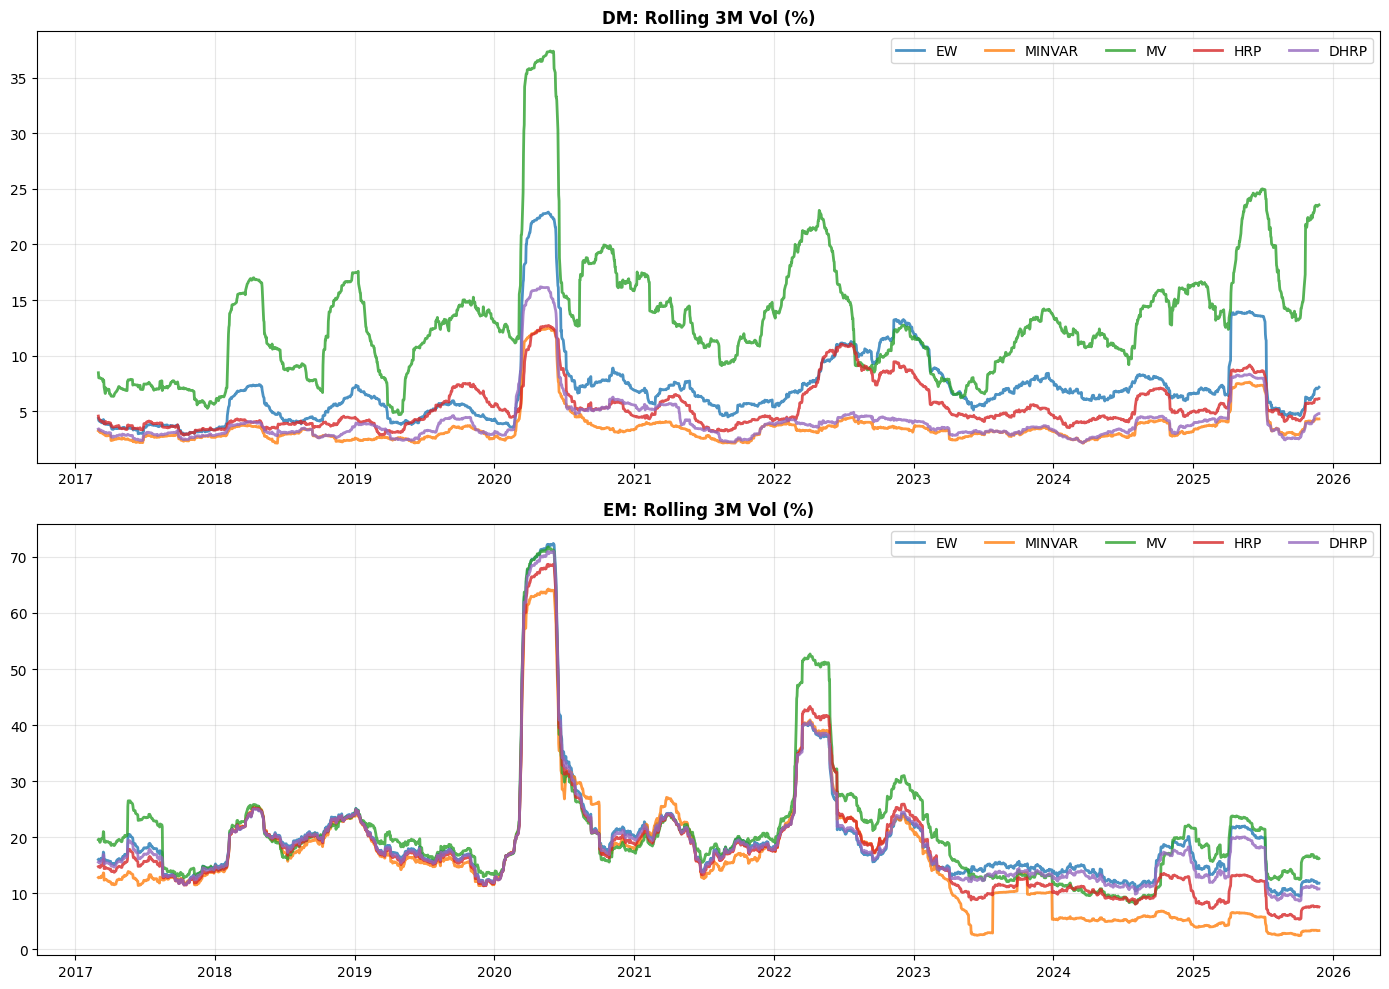

All visualizations saved to results/


In [22]:
# === COMPREHENSIVE VISUALIZATIONS ===
def get_series(res, m): return pd.Series(res[res['method']==m]['return'].values, index=pd.to_datetime(res[res['method']==m]['date'].values))
colors = plt.cm.tab10(np.linspace(0, 1, len(METHODS)))

# 1. Summary: Sharpe & Alpha
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
DM_table.plot(x='Method', y='Sharpe', kind='bar', ax=axes[0,0], legend=False, color='steelblue'); axes[0,0].set_title('DM: Sharpe'); axes[0,0].axhline(0, c='k', lw=0.8); axes[0,0].grid(axis='y', alpha=0.3)
EM_table.plot(x='Method', y='Sharpe', kind='bar', ax=axes[0,1], legend=False, color='coral'); axes[0,1].set_title('EM: Sharpe'); axes[0,1].axhline(0, c='k', lw=0.8); axes[0,1].grid(axis='y', alpha=0.3)
DM_table.plot(x='Method', y='Alpha_ann', kind='bar', ax=axes[1,0], legend=False, color='steelblue'); axes[1,0].set_title('DM: FF3 Alpha'); axes[1,0].axhline(0, c='k', lw=0.8); axes[1,0].grid(axis='y', alpha=0.3)
EM_table.plot(x='Method', y='Alpha_ann', kind='bar', ax=axes[1,1], legend=False, color='coral'); axes[1,1].set_title('EM: FF3 Alpha'); axes[1,1].axhline(0, c='k', lw=0.8); axes[1,1].grid(axis='y', alpha=0.3)
plt.tight_layout(); plt.savefig('results/summary.png', dpi=200); plt.show()

# 2. Correlation Heatmaps
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
dm_corr, em_corr = DM_prices.pct_change().dropna().corr(), EM_prices.pct_change().dropna().corr()
sns.heatmap(dm_corr, annot=True, fmt='.2f', cmap='RdBu_r', center=0, vmin=-1, vmax=1, ax=axes[0]); axes[0].set_title('DM: Correlation')
sns.heatmap(em_corr, annot=True, fmt='.2f', cmap='RdBu_r', center=0, vmin=-1, vmax=1, ax=axes[1]); axes[1].set_title('EM: Correlation')
plt.tight_layout(); plt.savefig('results/correlations.png', dpi=300); plt.show()
print(f"DM avg corr: {dm_corr.values[np.triu_indices_from(dm_corr.values, k=1)].mean():.3f}, EM: {em_corr.values[np.triu_indices_from(em_corr.values, k=1)].mean():.3f}")

# 3. Return Distributions
fig, axes = plt.subplots(2, len(METHODS), figsize=(4*len(METHODS), 8))
for i, m in enumerate(METHODS):
    for row, (res, col, lbl) in enumerate([(DM_results, 'steelblue', 'DM'), (EM_results, 'coral', 'EM')]):
        r = res[res['method']==m]['return'].values
        if r.size>0:
            axes[row,i].hist(r, bins=50, alpha=0.7, color=col, edgecolor='black', density=True)
            mu, sig = r.mean(), r.std()
            if sig>0: axes[row,i].plot(np.linspace(r.min(), r.max(), 100), norm.pdf(np.linspace(r.min(), r.max(), 100), mu, sig), 'r-', lw=2)
        axes[row,i].set_title(f'{lbl}: {m}', fontweight='bold'); axes[row,i].grid(alpha=0.3)
plt.suptitle('Return Distributions', fontsize=14, fontweight='bold', y=1.0)
plt.tight_layout(); plt.savefig('results/distributions.png', dpi=300); plt.show()

# 4. Rolling Sharpe
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))
for m in METHODS:
    s = get_series(DM_results, m); ax1.plot(s.index, s.rolling(252).mean()/s.rolling(252).std()*np.sqrt(252), label=m, lw=2, alpha=0.8)
    s = get_series(EM_results, m); ax2.plot(s.index, s.rolling(252).mean()/s.rolling(252).std()*np.sqrt(252), label=m, lw=2, alpha=0.8)
ax1.axhline(0, c='k', ls='--', alpha=0.5); ax1.set_title('DM: Rolling 1Y Sharpe', fontweight='bold'); ax1.legend(ncol=5); ax1.grid(alpha=0.3)
ax2.axhline(0, c='k', ls='--', alpha=0.5); ax2.set_title('EM: Rolling 1Y Sharpe', fontweight='bold'); ax2.legend(ncol=5); ax2.grid(alpha=0.3)
plt.tight_layout(); plt.savefig('results/rolling_sharpe.png', dpi=300); plt.show()

# 5. Cumulative Returns & Drawdowns
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
for idx, m in enumerate(METHODS):
    for col, (res, ax_r, ax_d) in enumerate([(DM_results, axes[0,0], axes[1,0]), (EM_results, axes[0,1], axes[1,1])]):
        s = get_series(res, m); cum = (1+s).cumprod()
        ax_r.plot(cum.index, cum.values, label=m, lw=2, color=colors[idx])
        dd = (cum - cum.expanding().max())/cum.expanding().max()
        ax_d.plot(dd.index, dd.values*100, label=m, lw=2, color=colors[idx])
for ax, t in [(axes[0,0], 'DM: Cumulative'), (axes[0,1], 'EM: Cumulative'), (axes[1,0], 'DM: Drawdown (%)'), (axes[1,1], 'EM: Drawdown (%)')]:
    ax.set_title(t, fontweight='bold'); ax.legend(fontsize=9); ax.grid(alpha=0.3)
axes[0,0].set_yscale('log'); axes[0,1].set_yscale('log')
axes[1,0].axhline(0, c='k', ls='--', alpha=0.5); axes[1,1].axhline(0, c='k', ls='--', alpha=0.5)
plt.tight_layout(); plt.savefig('results/cumulative_drawdown.png', dpi=300); plt.show()

# 6. Risk-Return Scatter
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
for m in METHODS:
    for res, ax, c in [(DM_results, ax1, 'steelblue'), (EM_results, ax2, 'coral')]:
        r = res[res['method']==m]['return'].values
        ax.scatter(r.std()*np.sqrt(252)*100, r.mean()*252*100, s=200, alpha=0.7, edgecolors='k', lw=2, color=c)
        ax.annotate(m, (r.std()*np.sqrt(252)*100, r.mean()*252*100), fontsize=10, fontweight='bold', ha='center', va='bottom', xytext=(0,8), textcoords='offset points')
ax1.set_xlabel('Vol (%)'); ax1.set_ylabel('Return (%)'); ax1.set_title('DM: Risk-Return', fontweight='bold'); ax1.grid(alpha=0.3)
ax2.set_xlabel('Vol (%)'); ax2.set_ylabel('Return (%)'); ax2.set_title('EM: Risk-Return', fontweight='bold'); ax2.grid(alpha=0.3)
plt.tight_layout(); plt.savefig('results/risk_return.png', dpi=300); plt.show()

# 7. Rolling Volatility
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))
for m in METHODS:
    s = get_series(DM_results, m); ax1.plot(s.index, s.rolling(63).std()*np.sqrt(252)*100, label=m, lw=2, alpha=0.8)
    s = get_series(EM_results, m); ax2.plot(s.index, s.rolling(63).std()*np.sqrt(252)*100, label=m, lw=2, alpha=0.8)
ax1.set_title('DM: Rolling 3M Vol (%)', fontweight='bold'); ax1.legend(ncol=5); ax1.grid(alpha=0.3)
ax2.set_title('EM: Rolling 3M Vol (%)', fontweight='bold'); ax2.legend(ncol=5); ax2.grid(alpha=0.3)
plt.tight_layout(); plt.savefig('results/rolling_volatility.png', dpi=300); plt.show()
print("All visualizations saved to results/")

In [23]:
# === ECONOMETRIC ANALYSIS ===
def max_dd(r): cum = (1+r).cumprod(); return ((cum - cum.expanding().max())/cum.expanding().max()).min()

print("="*60 + "\n1. MARKET CHARACTERISTICS\n" + "="*60)
for nm, pr in [('DM', DM_prices), ('EM', EM_prices)]:
    r = pr.pct_change().dropna()
    corr = r.corr().values[np.triu_indices_from(r.corr().values, k=1)].mean()
    print(f"{nm}: Vol={r.std().mean()*np.sqrt(252):.2%}, Corr={corr:.3f}, Diversification={(1-corr)*100:.1f}%")

print("\n" + "="*60 + "\n2. AR(1) PREDICTABILITY\n" + "="*60)
for nm, res in [('DM', DM_results), ('EM', EM_results)]:
    print(f"{nm}:", end=" ")
    for m in ['EW', 'HRP', 'DHRP']:
        r = res[res['method']==m]['return'].values
        if len(r)>50:
            sl, _, rv, pv, _ = linregress(r[:-1], r[1:])
            print(f"{m}: AR1={sl:.3f},R²={rv**2:.3f}", end=" | ")
    print()

print("\n" + "="*60 + "\n3. MAX DRAWDOWN & HIGHER MOMENTS\n" + "="*60)
for nm, res in [('DM', DM_results), ('EM', EM_results)]:
    print(f"\n{nm}:")
    for m in METHODS:
        r = res[res['method']==m]['return'].values
        if len(r)==0: continue
        print(f"  {m}: MaxDD={max_dd(pd.Series(r)):.2%}, Skew={skew(r):.2f}, ExKurt={kurtosis(r):.2f}")

print("\n" + "="*60 + "\n4. DM vs EM COMPARISON\n" + "="*60)
comp = []
for m in METHODS:
    dm_r, em_r = DM_results[DM_results['method']==m]['return'].values, EM_results[EM_results['method']==m]['return'].values
    dm_mu, em_mu = dm_r.mean()*252, em_r.mean()*252
    dm_vol, em_vol = dm_r.std()*np.sqrt(252), em_r.std()*np.sqrt(252)
    t, p = ttest_ind(dm_r, em_r)
    comp.append({'Method': m, 'DM_Ret': f"{dm_mu:.2%}", 'EM_Ret': f"{em_mu:.2%}", 
                'DM_Vol': f"{dm_vol:.2%}", 'EM_Vol': f"{em_vol:.2%}", 'Vol_Ratio': f"{dm_vol/em_vol:.2f}", 'T_stat': f"{t:.2f}", 'P_val': f"{p:.3f}"})
print(pd.DataFrame(comp).to_string(index=False))

print("\n" + "="*60 + "\n5. INFORMATION RATIO vs EW\n" + "="*60)
for nm, res in [('DM', DM_results), ('EM', EM_results)]:
    ew = res[res['method']=='EW']['return'].values
    print(f"{nm}:", end=" ")
    for m in ['MINVAR', 'MV', 'HRP', 'DHRP']:
        mr = res[res['method']==m]['return'].values
        if len(mr)==len(ew) and len(mr)>0:
            exc = mr - ew
            if exc.std()>0: print(f"{m}: IR={(exc.mean()*252)/(exc.std()*np.sqrt(252)):.3f}", end=" | ")
    print()

1. MARKET CHARACTERISTICS
DM: Vol=14.46%, Corr=-0.008, Diversification=100.8%
EM: Vol=28.03%, Corr=0.551, Diversification=44.9%

2. AR(1) PREDICTABILITY
DM: EW: AR1=-0.062,R²=0.004 | HRP: AR1=-0.010,R²=0.000 | DHRP: AR1=-0.194,R²=0.038 | 
EM: EW: AR1=-0.160,R²=0.026 | HRP: AR1=-0.156,R²=0.024 | DHRP: AR1=-0.161,R²=0.026 | 

3. MAX DRAWDOWN & HIGHER MOMENTS

DM:
  EW: MaxDD=-16.31%, Skew=-0.34, ExKurt=13.34
  MINVAR: MaxDD=-7.91%, Skew=-0.57, ExKurt=20.74
  MV: MaxDD=-21.14%, Skew=-0.30, ExKurt=8.04
  HRP: MaxDD=-8.16%, Skew=-0.04, ExKurt=4.44
  DHRP: MaxDD=-8.22%, Skew=-0.65, ExKurt=21.26

EM:
  EW: MaxDD=-49.73%, Skew=-1.08, ExKurt=15.58
  MINVAR: MaxDD=-53.16%, Skew=-1.00, ExKurt=17.43
  MV: MaxDD=-60.44%, Skew=-1.37, ExKurt=15.12
  HRP: MaxDD=-50.30%, Skew=-1.01, ExKurt=17.11
  DHRP: MaxDD=-49.61%, Skew=-1.07, ExKurt=16.03

4. DM vs EM COMPARISON
Method DM_Ret EM_Ret DM_Vol EM_Vol Vol_Ratio T_stat P_val
    EW  8.72%  5.52%  7.84% 22.09%      0.35   0.41 0.682
MINVAR  4.83%  2.46%  